In [1]:
import rclpy, asyncio
import matplotlib.pyplot as plt
import numpy as np
from subscriber import Subscriber, get_observation, wait_for_message
from sensor_msgs.msg import Image
from std_msgs.msg import String, Float32MultiArray
from time import sleep

In [2]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

/home/irobotics/anaconda3/envs/octo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
PATH_CHECKPOINTS = "/media/irobotics/Transcend/finetuned_checkpoints/v5_delta_checkpoints/"
PATH_DATASET_TFDS = '/media/irobotics/Transcend/tensorflow_datasets/v5_test_delta/example_dataset/1.0.0/'
PATH_INFERENCE_RESULTS = "/media/irobotics/Transcend/inference_result/"

In [4]:
from octo.model.octo_model import OctoModel

model = OctoModel.load_pretrained(PATH_CHECKPOINTS)

2024-10-24 14:33:44.931535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 14:33:44.931573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 14:33:44.957092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 14:33:45.728119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/irobotics/anaconda3/envs/octo/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in

In [5]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir=PATH_DATASET_TFDS)
ds = builder.as_dataset(split='train[:2]')
iterator = iter(ds)
episode = next(iterator)
# sample episode + resize to 256x256 (default third-person cam resolution)
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]
images_wrist = [cv2.resize(np.array(step['observation']['wrist_image']), (256, 256)) for step in steps]
# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[10]['language_instruction'].numpy().decode()

2024-10-24 14:34:05.246870: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
builder = tfds.builder_from_directory(builder_dir=PATH_DATASET_TFDS)
ds = builder.as_dataset(split='train[:2]')
iterator = iter(ds)

In [7]:
episode = next(iterator)
episode

{'episode_metadata': {'file_path': <tf.Tensor: shape=(), dtype=string, numpy=b'data/train/episode_2.npy'>},
 'steps': <_VariantDataset element_spec={'action': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'observation': {'image': TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), 'state': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'wrist_image': TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>}

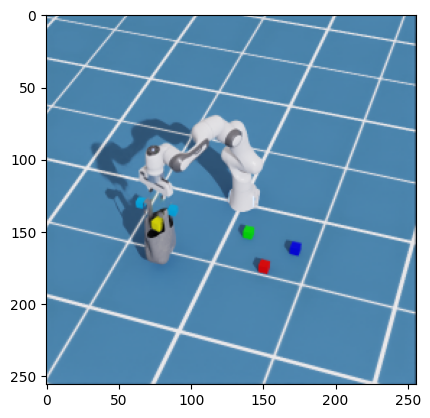

In [8]:
plt.imshow(images[-1])
plt.show()

### Inference begins

In [9]:
# create `task` dict
# task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(goals={"image_primary": goal_image})
task = model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [10]:
rclpy.init(args=None)
node = Subscriber()
publisher = node.create_publisher(Float32MultiArray, 'online_eff_topic', 10)
pub_msg = Float32MultiArray()

In [12]:
# collect predicted and true actions
pred_delta_actions= []
window = 1
input_images_stack = [np.zeros((256, 256, 3)) for _ in range(window)]
input_images_wrist_stack = [np.zeros((256, 256, 3)) for _ in range(window)]

input_images = get_observation(node, Image, '/Camera_rgb')
input_images_wrist = get_observation(node, Image, '/Camera_wrist_rgb')

## initialize the stack with the first image
# input_images = images[0]
# input_images_wrist = images_wrist[0]

# input_images_stack = [input_images]
# input_images_wrist_stack = [input_images_wrist]

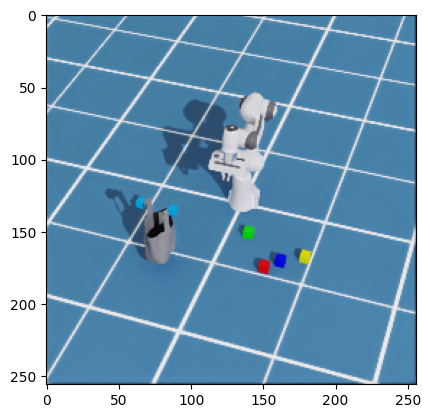

In [13]:
plt.imshow(input_images)

In [14]:
async def publish_efforts(pub_msg, trigger):
    input_images, input_images_wrist = None, None
    if not trigger:
        print("Start publishing target eff pose: ", pub_msg.data)
        for _ in range(200):
            publisher.publish(pub_msg)
            await asyncio.sleep(0.1)
        print("Start getting new observation")
        asyncio.sleep(1)
        input_images = get_observation(node, Image, '/Camera_rgb')
        input_images_wrist = get_observation(node, Image, '/Camera_wrist_rgb')
    else:
        cur_eff = wait_for_message(node, Float32MultiArray, '/eff_topic').data[0:3]
        delta = np.array(pub_msg.data[0:3]) - cur_eff
        gripper_eff = pub_msg.data[3]
        for i in range(4):
            cur_eff += delta/2
            pub_msg.data = cur_eff.tolist()
            pub_msg.data.append(gripper_eff)
            print(f"{i}th triggering: ", pub_msg.data)
            for _ in range(50):
                publisher.publish(pub_msg)
                await asyncio.sleep(0.1)
        print("Start getting new observation")
        input_images = get_observation(node, Image, '/Camera_rgb')
        input_images_wrist = get_observation(node, Image, '/Camera_wrist_rgb')

    return input_images, input_images_wrist

In [15]:
import warnings
warnings.filterwarnings("ignore")
trigger = False
while True:

    observation = {
        'image_primary': np.stack(input_images_stack)[None],
        'image_wrist': np.stack(input_images_wrist_stack)[None],
        'timestep_pad_mask': np.full((1, np.stack(input_images_stack)[None].shape[1]), True, dtype=bool)
    }

    # one step actions
    actions = model.sample_actions(
        observation, 
        task, 
        unnormalization_statistics=model.dataset_statistics["action"], 
        rng=jax.random.PRNGKey(0)
    )
    actions = actions[0] # remove batch dim
    print("Predicted delta actions: ", actions[0,:4].tolist())
    pred_delta_actions.append(actions[0,:4].tolist()) # save predicted actions

    # publish actions to robot
    pred_eff = actions[0,:3].tolist()
    pred_gripper = 1 if actions[0,3] > 0.5 else 0

    cur_eff = wait_for_message(node, Float32MultiArray, '/eff_topic').data[0:3] # Test: get current eff, should work well

    pub_msg.data = list(np.array(pred_eff) + np.array(cur_eff))
    pub_msg.data.append(pred_gripper)
    input_images, input_images_wrist = asyncio.run(publish_efforts(pub_msg, trigger))

    if input_images is not None and input_images_wrist is not None:
        print("New images received")
        ## create image stack
        # input_images_stack.pop(0)
        # input_images_wrist_stack.pop(0)

        # input_images_stack = []
        # input_images_wrist_stack = []
        # input_images_stack.append(initial_input_images)
        # input_images_wrist_stack.append(initial_input_images_wrist)
        # input_images_stack.append(input_images)
        # input_images_wrist_stack.append(input_images_wrist)

        input_images_stack = [input_images]
        input_images_wrist_stack = [input_images_wrist]
        
    else:
        print("No new images received")
        continue

Predicted actions:  [-0.019068919122219086, -0.05313883349299431, -0.01653018780052662, 0.032958388328552246]
Start getting new observation


New images received


Predicted actions:  [-0.0013054599985480309, 0.00795641727745533, -0.042632877826690674, -0.009780711494386196]
Start getting new observation
New images received
Predicted actions:  [-0.012828417122364044, 0.0069260792806744576, -0.050757624208927155, 0.05005000904202461]


KeyboardInterrupt: 

In [ ]:
### publish random actions
pub_msg.data = [0.39701533, 0.12148877, 0.25303242]

for i in range(200):
    publisher.publish(pub_msg)
    sleep(0.1)

In [ ]:
node.destroy_node()
rclpy.shutdown()